In [2]:
import lsd
from scipy.spatial.distance import cdist

In [5]:
import cv2
import numpy as np

from pygo.Webcam import Webcam
from pygo.utils.image import *
from pygo.utils.line import point_in_circle
from skimage import segmentation

from skimage import data, io, segmentation, color
from skimage.future import graph
import numpy as np
from skimage import data, img_as_float
from skimage.filters import sobel, sobel_h, sobel_v, threshold_local

from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)
from skimage.restoration import inpaint
import ipyplot
from pygo.GoBoard import GoBoard
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20,20]
from skimage import (
    data, restoration, util
)
import logging
logging.debug = 5
logging.addLevelName(logging.debug, "debug")
logging.Logger.debug = lambda inst, msg, *args, **kwargs: inst.log(logging.debug, msg, *args, **kwargs)
logging.debug = lambda msg, *args, **kwargs: logging.log(logging.debug, msg, *args, **kwargs)


from pygo.Webcam import Webcam
ipt_ = Webcam()
from pygo.GoBoard import GoBoard
board = GoBoard(ipt_.getCalibration())


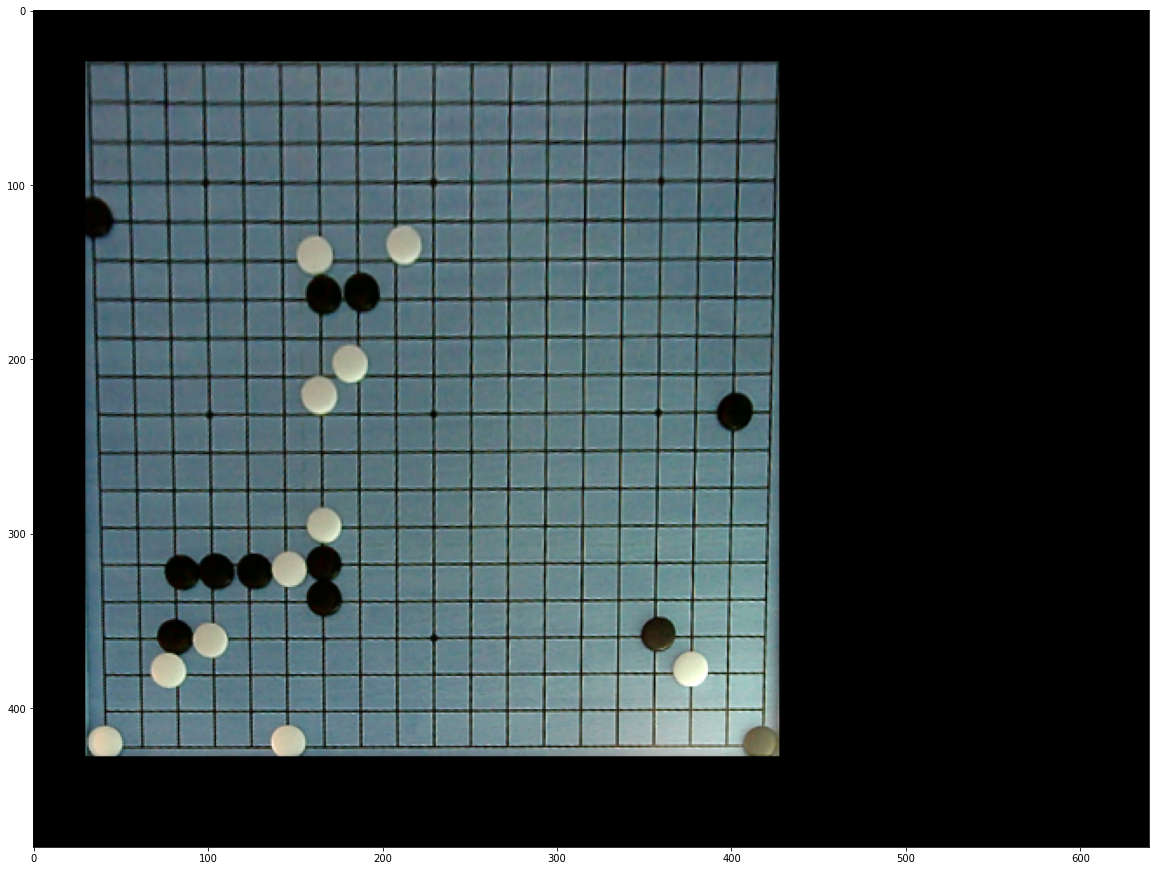

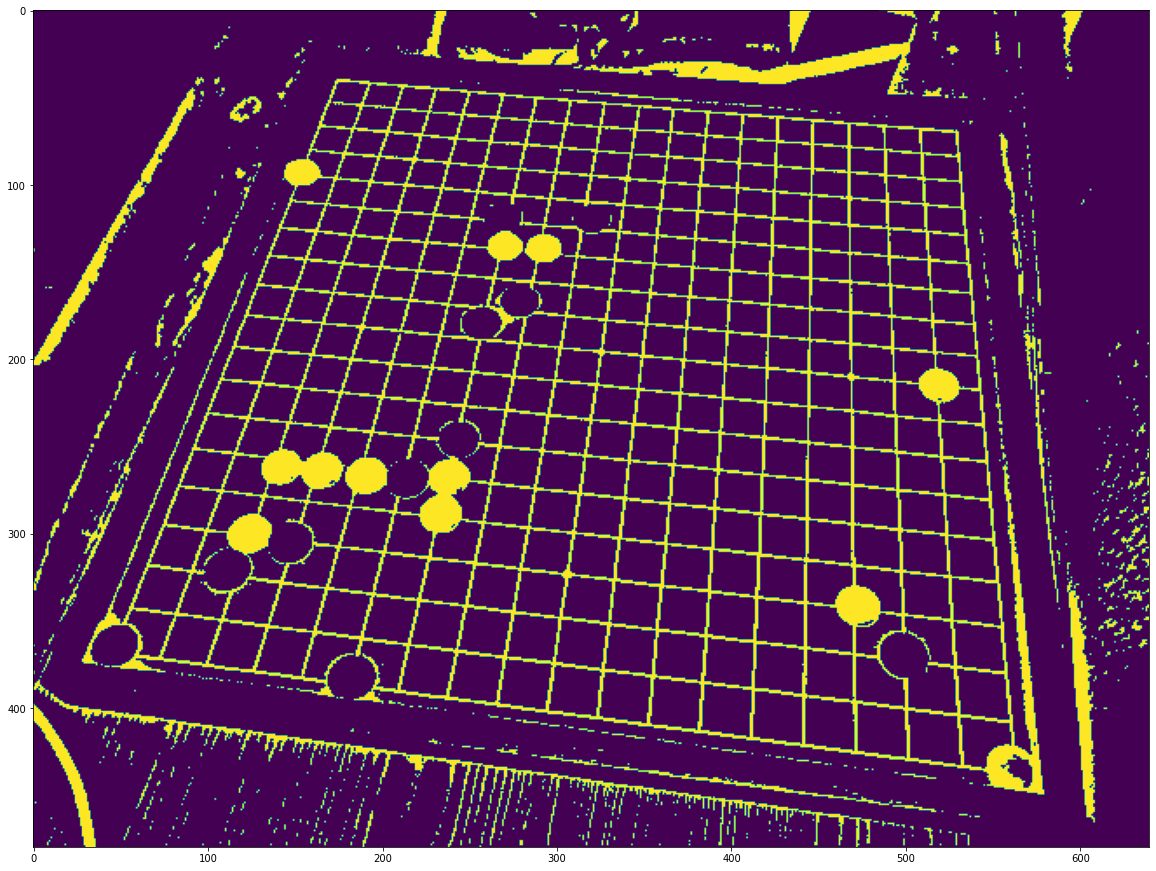

In [21]:
img_color = cv2.imread('debug/10.png')
corners = board.track_corners(img_color)
img_ = img_color.copy()
board.update_grid(img_color, corners)
c = np.squeeze(corners)
cH = cv2.convertPointsToHomogeneous(c)

#convert corners into rectified version
cHw = []
for crn in cH:
    pt = np.linalg.inv(board.H) @ crn.T
    cHw.append(cv2.convertPointsFromHomogeneous(pt.T))
cHw = np.squeeze(np.array(cHw),1).astype(int)


# mask everything outside
H,W = board.img_limits
mask = np.zeros((W,H), dtype=np.uint8)
mask = cv2.fillConvexPoly(mask, cHw, 255)
mask = cv2.bitwise_not(mask)

# warp image and mask
if corners is not None:
    corners = np.int32([corners])
    #cv2.polylines(img_, corners, color=(0,255,0), isClosed=True, thickness=3)
img_ = cv2.warpPerspective(img_, np.linalg.inv(board.H), board.img_limits)
img_[mask==255] = 0

# detect lines -> when the corners are correct the lines should be almost perfectly
# vertical and horizontal
lines = lsd.lsd_with_line_merge(img_)
plt.imshow(img_)
plt.show()

plt.imshow(board.binarizeImage(img_color))
plt.show()

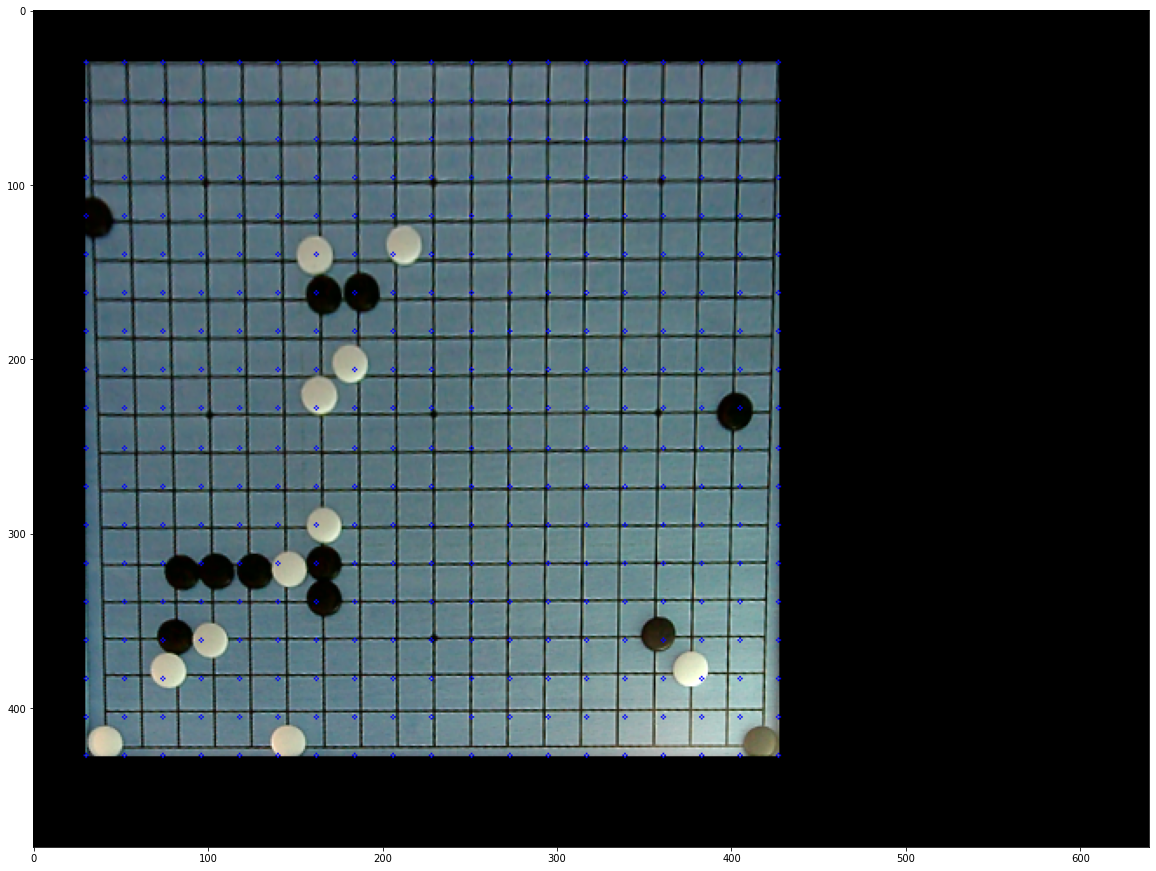

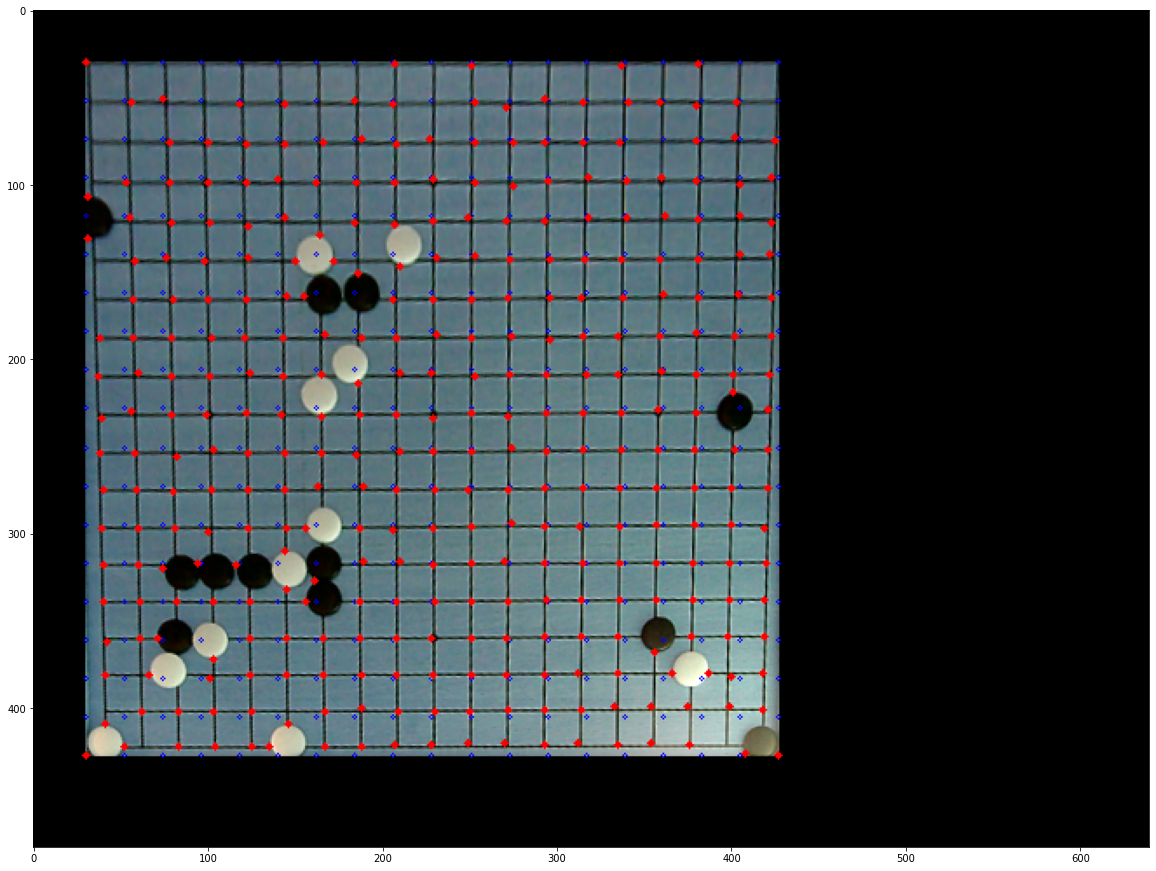

In [22]:
img__ = toGrayImage(img_)
ft = cv2.goodFeaturesToTrack(img__, 19*19, 0.01, 10)

for c in board.go_board_shifted:
    cv2.circle(img_, c.astype(int), 1, (0,0,255), 1)

for i in np.int0(ft):    
    x,y = i.ravel()
    #cv2.circle(img_,(x,y),3, (0,255,0),-1)
plt.imshow(img_)
plt.show()

ft = np.squeeze(ft)
dists = cdist(board.go_board_shifted, ft)
paired = []
for i, c in enumerate(board.go_board_shifted):
    paired.append(ft[np.argmin(dists[i])])
    cv2.circle(img_, paired[-1].astype(int), 2, (255,0,0), -1)
plt.imshow(img_)
plt.show()
paired = np.array(paired)


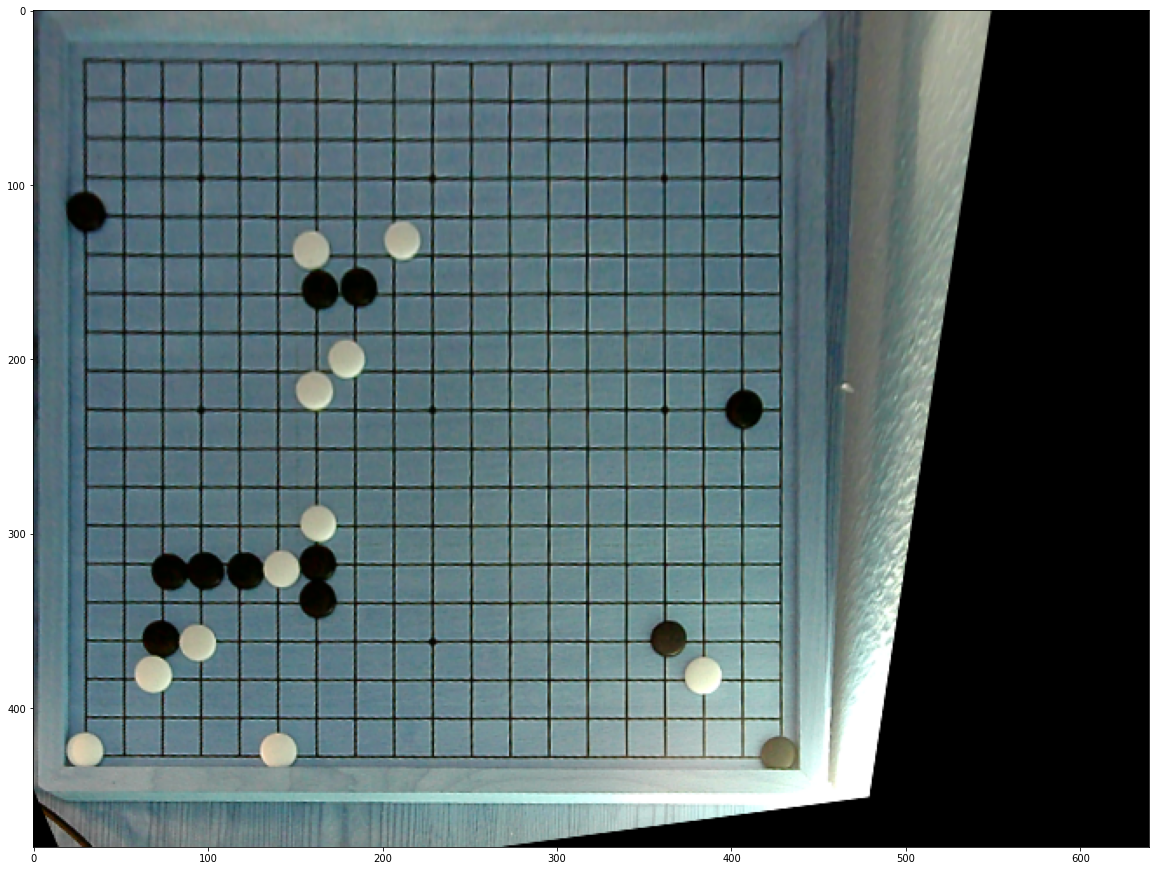

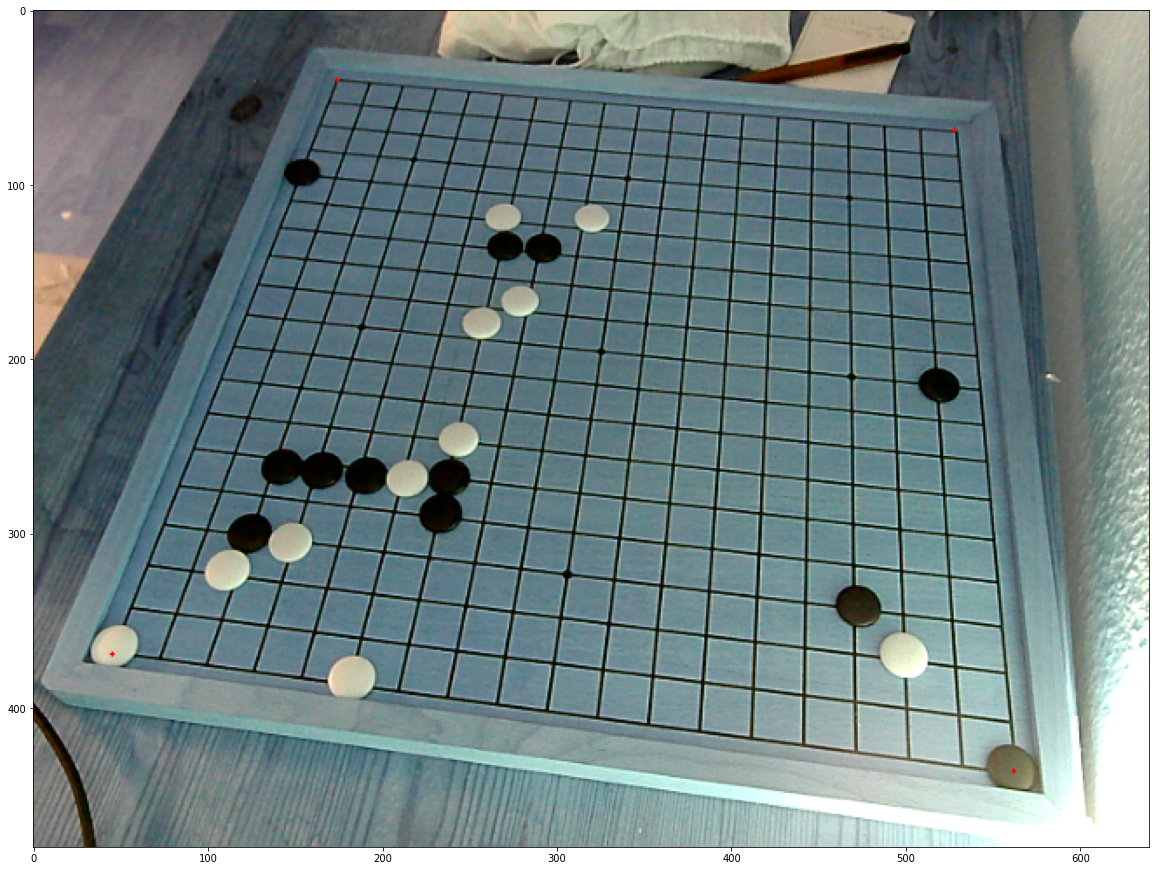

In [41]:
img_out = img_color.copy()
H = cv2.findHomography(board.go_board_shifted, paired, cv2.LMEDS)[0]

img_warped = cv2.warpPerspective(img_color, np.linalg.inv(H)@np.linalg.inv(board.H), board.img_limits)
plt.imshow(img_warped)
plt.show()

H = np.linalg.inv(H)@np.linalg.inv(board.H)

# warp corners back
#convert corners into rectified version
c = []
corners__ = []
corners__.append(board.go_board_shifted.reshape(19,19,2)[0,0])
corners__.append(board.go_board_shifted.reshape(19,19,2)[0,18])
corners__.append(board.go_board_shifted.reshape(19,19,2)[18,18])
corners__.append(board.go_board_shifted.reshape(19,19,2)[18,0])


for crn in corners__:
    crn = np.array([[crn[0], crn[1], 1]])
    pt = np.linalg.inv(H) @ crn.T
    c.append(cv2.convertPointsFromHomogeneous(pt.T))
    cv2.circle(img_out, np.squeeze(c[-1]).astype(int), 1, (255,0,0), -1)
c = np.squeeze(np.array(c),1).astype(int)
plt.imshow(img_out)
plt.show()




In [45]:
def mask_outside_board(corners, img):
    
    mask = np.zeros_like(img, dtype=np.uint8)
    cv2.fillPoly(mask, corners, 255)
    mask = cv2.bitwise_not(mask)
    img[mask==255] = 0
    return img

<ipython-input-62-d156e65f9e24>:18: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  corners_warped = np.array([corners__]).astype(np.int)


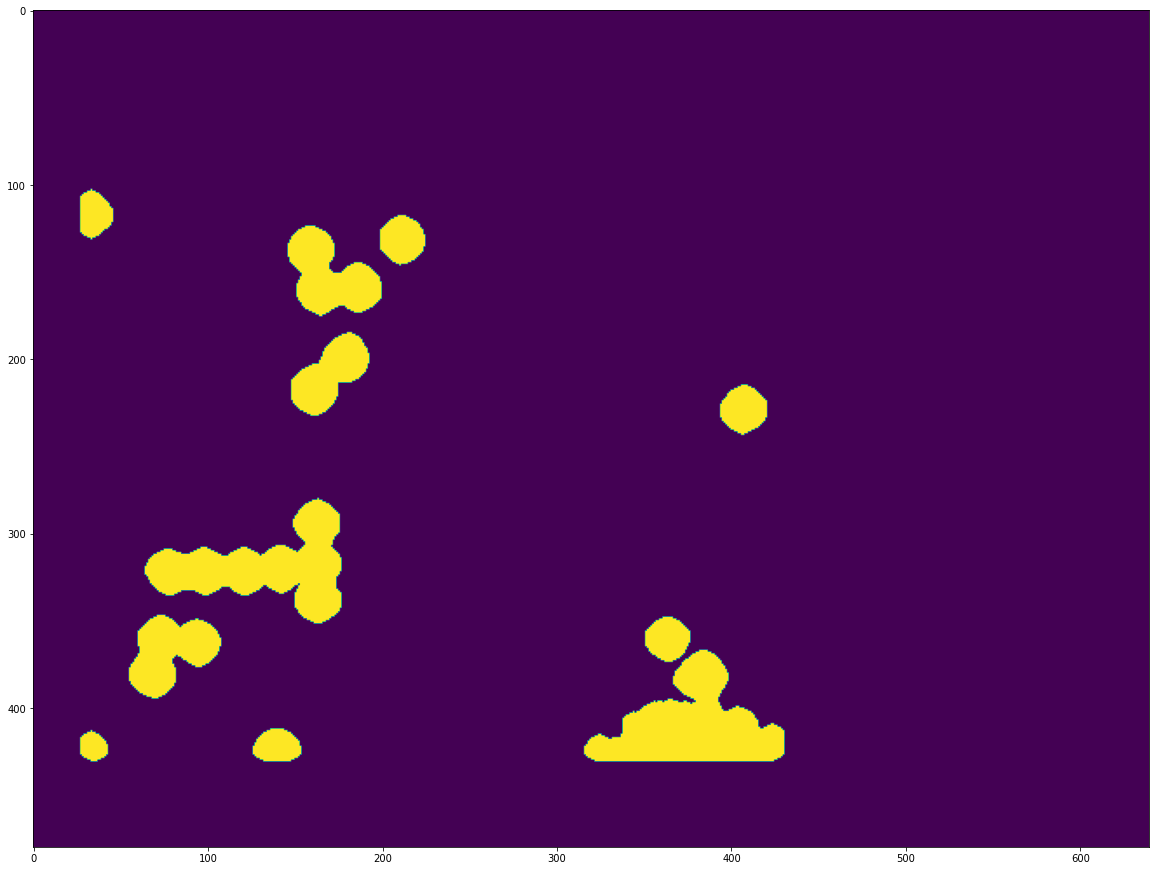

In [62]:
# detect round objects
def mask_stones(img):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(img, 11)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    thresh = cv2.bitwise_not(thresh)
    thresh = mask_outside_board(corners_warped, thresh)

    # Morph open 
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7,7))
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    opening = cv2.dilate(opening, kernel)

    return opening


corners_warped = np.array([corners__]).astype(np.int)

img_warped_2 = cv2.cvtColor(img_warped, cv2.COLOR_RGB2GRAY)
img_warped_3 = mask_outside_board(corners_warped, img_warped_2)
mask_black = mask_stones(img_warped_3)

img_warped_neg = toCMYKImage(img_warped)[:,:,2]
img_warped_neg = mask_outside_board(corners_warped, img_warped_neg)
mask_white = mask_stones(img_warped_neg)

mask = cv2.bitwise_or(mask_black, mask_white)
plt.imshow(mask)
plt.show()


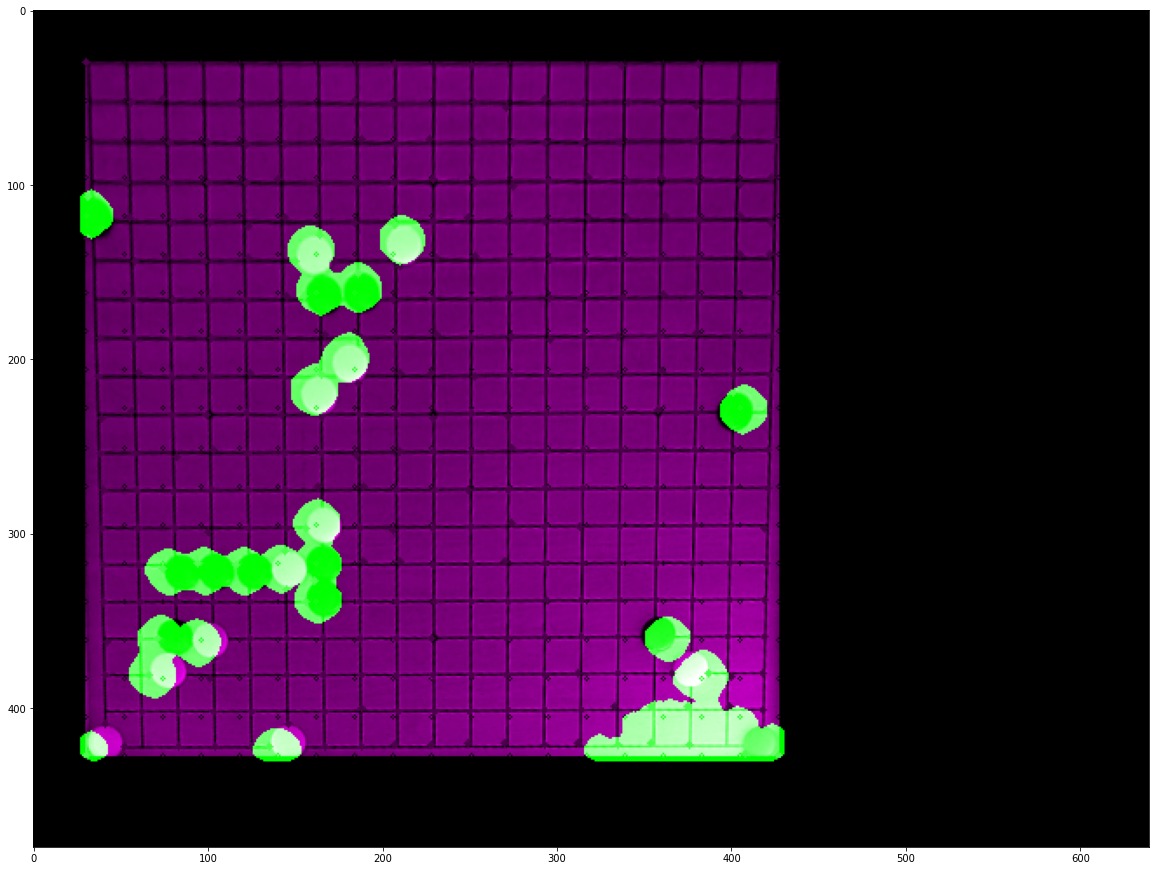

In [65]:
i = cv2.cvtColor(img_, cv2.COLOR_RGB2GRAY)

plt.imshow(np.dstack((i, mask, i)))
plt.show()

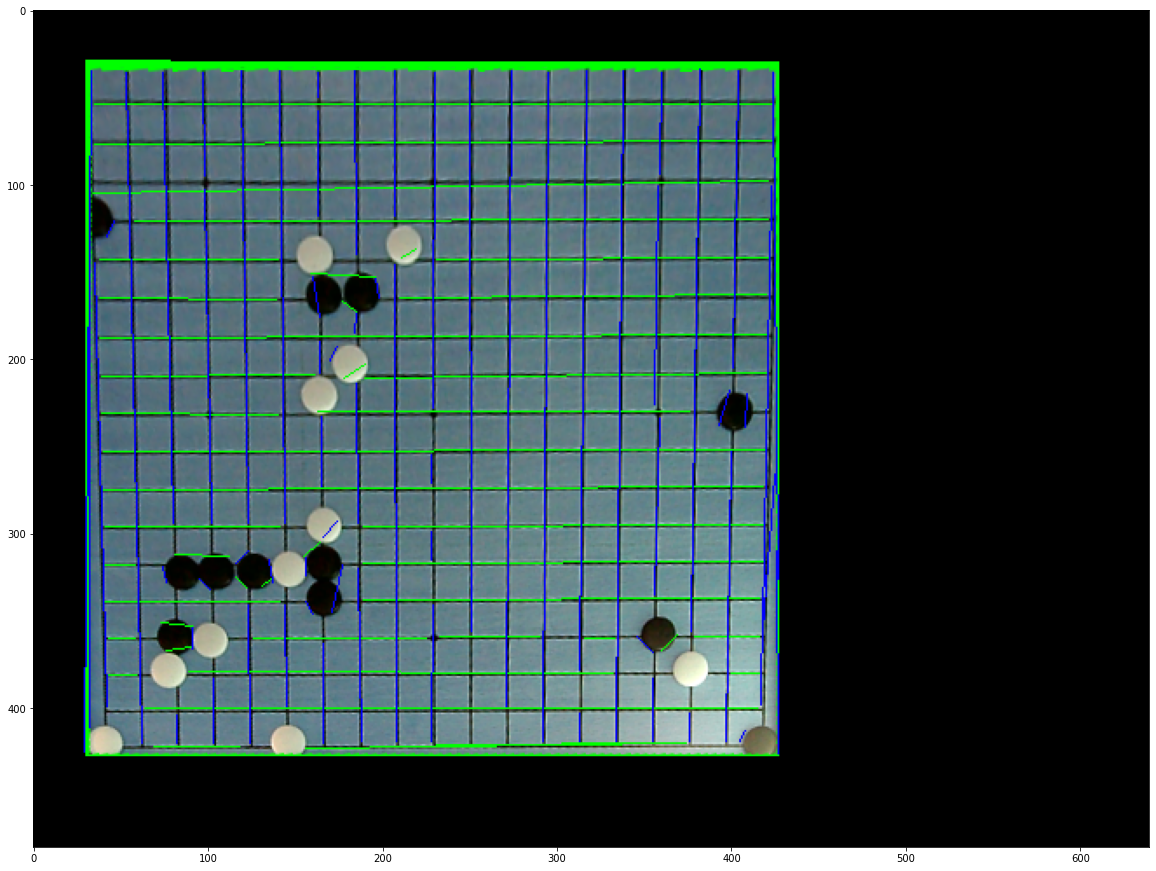

In [21]:
for l in lines[1]:
    start = np.array(l[:2]).astype(int)
    end = np.array(l[2:]).astype(int)
    cv2.line(img_, start, end, color=(0,0,255))
plt.imshow(img_)
plt.show()

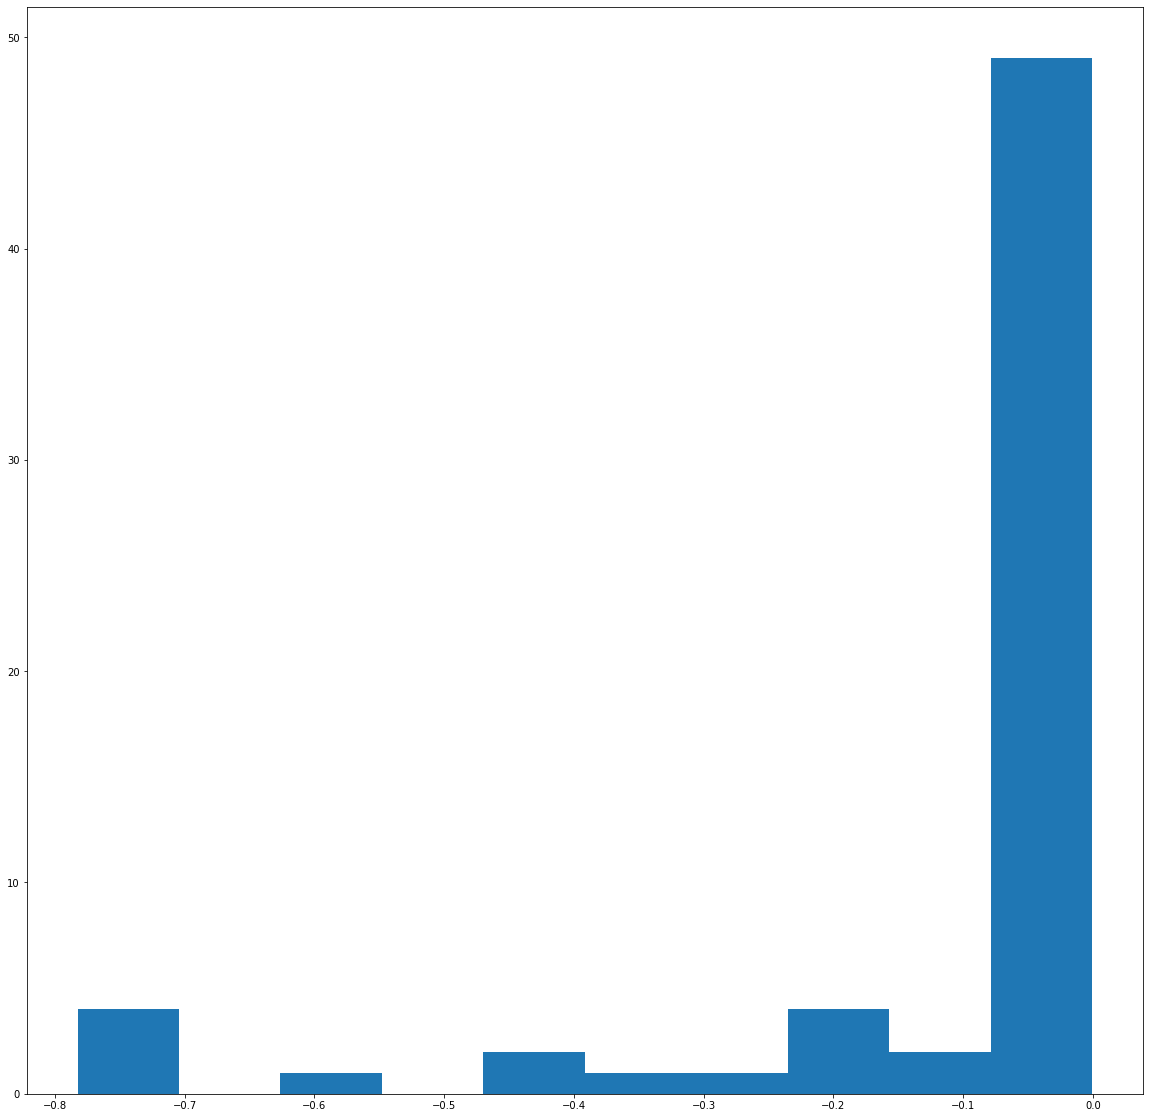

In [24]:
def analyze_lines(lns):
    v_ = []
    for l in lns:
        dx = np.abs(l[0] - l[2])
        dy = np.abs(l[1] - l[3])
        v_.append(np.arctan2(dy, dx)-np.pi/2)
    
    plt.hist(v_)
    plt.show()
analyze_lines(lines[1])

In [119]:
img_gray = toGrayImage(img.copy())
img_bin = board.binarizeImage(img_color.copy()).astype(np.uint8)
img_gray.dtype
img_bin.dtype


dtype('uint8')

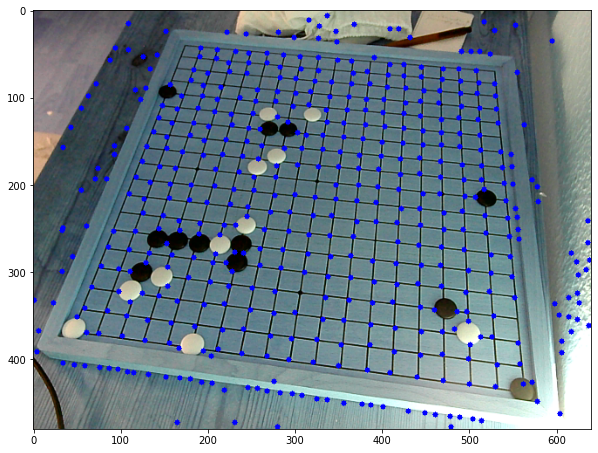

(<matplotlib.image.AxesImage at 0x7f88f7d32cd0>, None)

In [42]:
ft = cv2.goodFeaturesToTrack(img_bin, 22*22, 0.01, 10)
for i in np.int0(ft):
    
    x,y = i.ravel()
    cv2.circle(img_color,(x,y),3, (0,0,255),-1)
plt.imshow(img_color),plt.show()

In [47]:
pts_target = []
for i in range(19):
    for j in range(19):
        pts_target.append(np.array([i*20, j*20]))
pts_target = np.array(pts_target)
pts_target = pts_target[:, None, :]



(484, 1, 2)

In [48]:
fmat = cv2.findHomography(pts_target, ft, method=cv2.RANSAC)

error: OpenCV(4.5.2) /tmp/pip-req-build-eirhwqtr/opencv/modules/calib3d/src/fundam.cpp:389: error: (-215:Assertion failed) src.checkVector(2) == dst.checkVector(2) in function 'findHomography'
